In [1]:
import pandas as pd
import numpy as np
from sklearn import tree

In [2]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [3]:
x = ames_sample['Lot Frontage']
y = ames_sample['SalePrice']

In [4]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


In [5]:
x = ames_sample['Lot Area']
y = ames_sample['SalePrice']

In [6]:
print(find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice']))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


In [7]:
ames_data = ames_data[(ames_data["Lot Frontage"] <=150) & (ames_data["Lot Area"] <=20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

In [8]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params, min_weighted_impurity

In [9]:
optimal_split_params = best_split(X, y, criterion=squared_error)

print('Optimal j: {}'.format(optimal_split_params[0][0]))
print('Optimal t: {}'.format(optimal_split_params[0][1]))
print('min_weighted_impurity: {}'.format(optimal_split_params[1]))


Optimal j: 0
Optimal t: 71.0
min_weighted_impurity: 1414654917.0222223


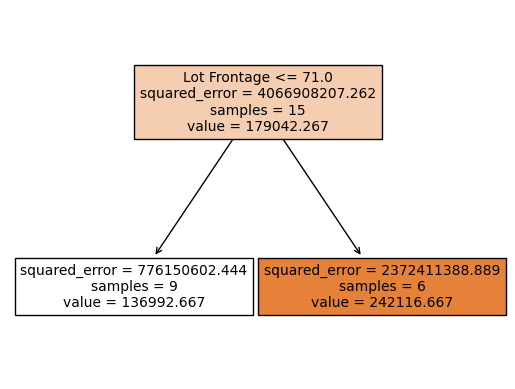

In [10]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [11]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [12]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

In [13]:
optimal_params = best_split(X, y, criterion=entropy)

print('Optimal j: {}'.format(optimal_params[0][0]))
print('Optimal t: {}'.format(optimal_params[0][1]))
print('min_weighted_impurity: {}'.format(optimal_params[1]))

Optimal j: 1
Optimal t: 3.22085
min_weighted_impurity: 0.45977313014931737


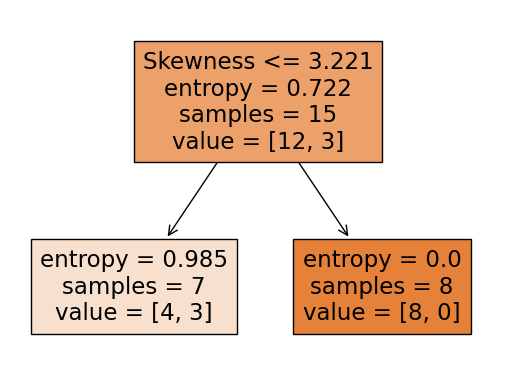

In [14]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [17]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

# Создаем обучающую выборку
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

IndexingError: Too many indexers

In [18]:
# Создаем модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Печатаем дерево решений в виде списка условий
print(tree.export_text(decision_tree=dt))

|--- feature_1 <= 3.22
|   |--- feature_0 <= 2.76
|   |   |--- feature_0 <= -1.25
|   |   |   |--- class: 0
|   |   |--- feature_0 >  -1.25
|   |   |   |--- feature_0 <= -0.06
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  -0.06
|   |   |   |   |--- feature_0 <= 0.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.99
|   |   |   |   |   |--- class: 1
|   |--- feature_0 >  2.76
|   |   |--- class: 0
|--- feature_1 >  3.22
|   |--- class: 0

